In [2]:
%load_ext autoreload
%autoreload 2

In [39]:
import pandas as pd
import pickle
import re
import scipy
import random
from dime_take_home.utils import get_locations_from_text
import collections

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})  

pd.options.mode.chained_assignment = None  # default is 'warn'


## Try [WB Monthly food price data](https://microdata.worldbank.org/index.php/catalog/4483/get-microdata)
This can be downloaded manually and placed in `data` folder

In [4]:
df = pd.read_csv('../data/external/WLD_RTFP_mkt_2024-07-01.csv')

In [5]:
df.head()

,ISO3,country,adm1_name,adm2_name,mkt_name,lat,lon,geo_id,DATES,year,...,l_yogurt,c_yogurt,inflation_yogurt,trust_yogurt,o_food_price_index,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index
0,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-01-01,2007,...,NaN,NaN,NaN,NaN,0.60,0.62,0.60,0.60,NaN,7.8
1,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-02-01,2007,...,NaN,NaN,NaN,NaN,0.61,0.62,0.60,0.61,NaN,7.8
2,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-03-01,2007,...,NaN,NaN,NaN,NaN,0.62,0.63,0.61,0.62,NaN,7.8
3,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-04-01,2007,...,NaN,NaN,NaN,NaN,0.62,0.65,0.61,0.65,NaN,7.8
4,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-05-01,2007,...,NaN,NaN,NaN,NaN,0.66,0.70,0.65,0.70,NaN,7.8


In [ ]:
df = df[df['ISO3'].isin(['SYR','IRQ','LBN','PSE','JOR'])]
df = df[df['year'] == 2024]
df = df[df['DATES'].isin( ['2024-06-01','2024-07-01'])]
# Dro other countries and time periods

In [ ]:
df.groupby('ISO3').size()
# Quick count of coverage

ISO3
IRQ     40
LBN     54
SYR    196
dtype: int64

In [ ]:
df.shape
# Many columns, drop some

(290, 536)

In [9]:
df.isnull().sum().sort_values(ascending=False).head(300)

trust_sorghum_food_aid        290
inflation_sorghum_food_aid    290
c_sorghum_food_aid            290
l_sorghum_food_aid            290
h_sorghum_food_aid            290
                             ... 
cheese                        263
dates                         262
inflation_fish                250
c_fish                        250
o_fish                        250
Length: 300, dtype: int64

In [ ]:
df = df.dropna(axis=1, how='all')
# Drop the null columns

df = df.loc[:, df.isnull().mean() < 0.8]
# Drop the 80% or more null columns

In [ ]:
df['DATES'] = pd.to_datetime(df['DATES'])
df.set_index('DATES', inplace=True)
# Index by date

## Focus on food price inflation 
### Group by country and admin2 region. Take mean where data is available from multiple markets

First plot out - Some admin-2s have measurements from multiple markets. Plot all, but take mean for downstream calculations

In [ ]:
ylim_dict = {iso: [group['inflation_food_price_index'].min(), group['inflation_food_price_index'].max()] 
                for iso, group in df.groupby('ISO3')}
# For plotting need correct y axis scale per country

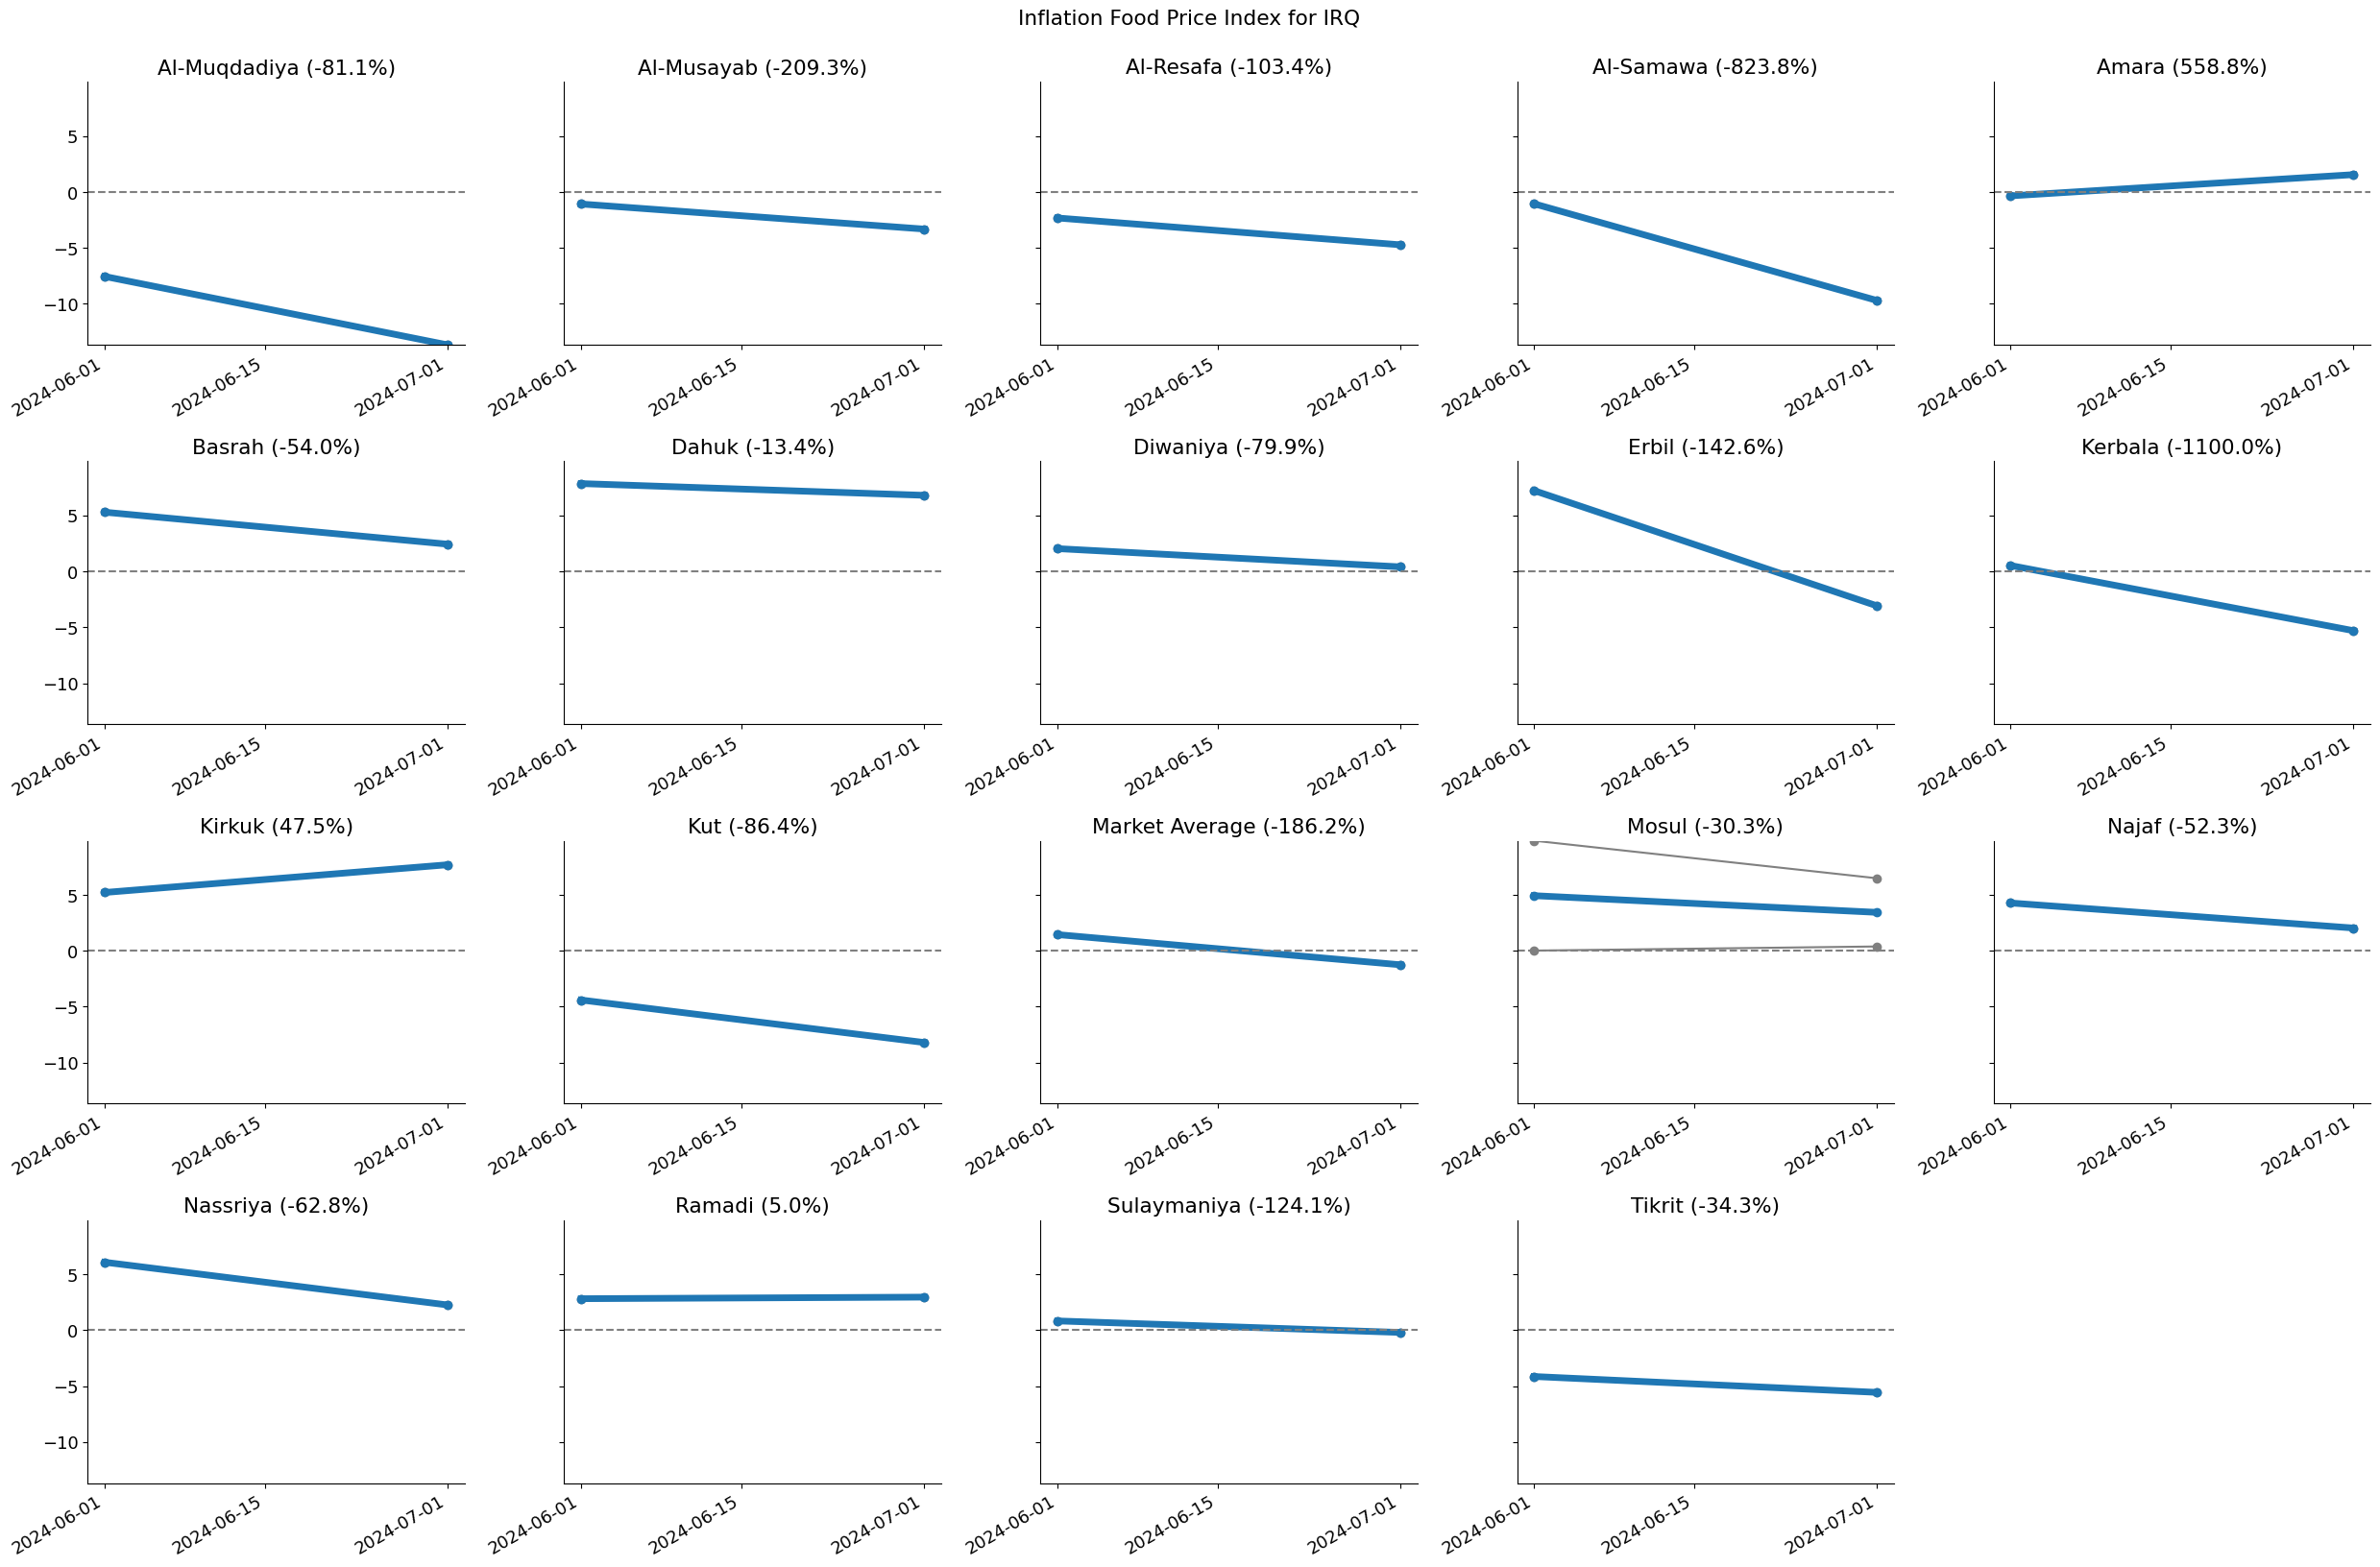

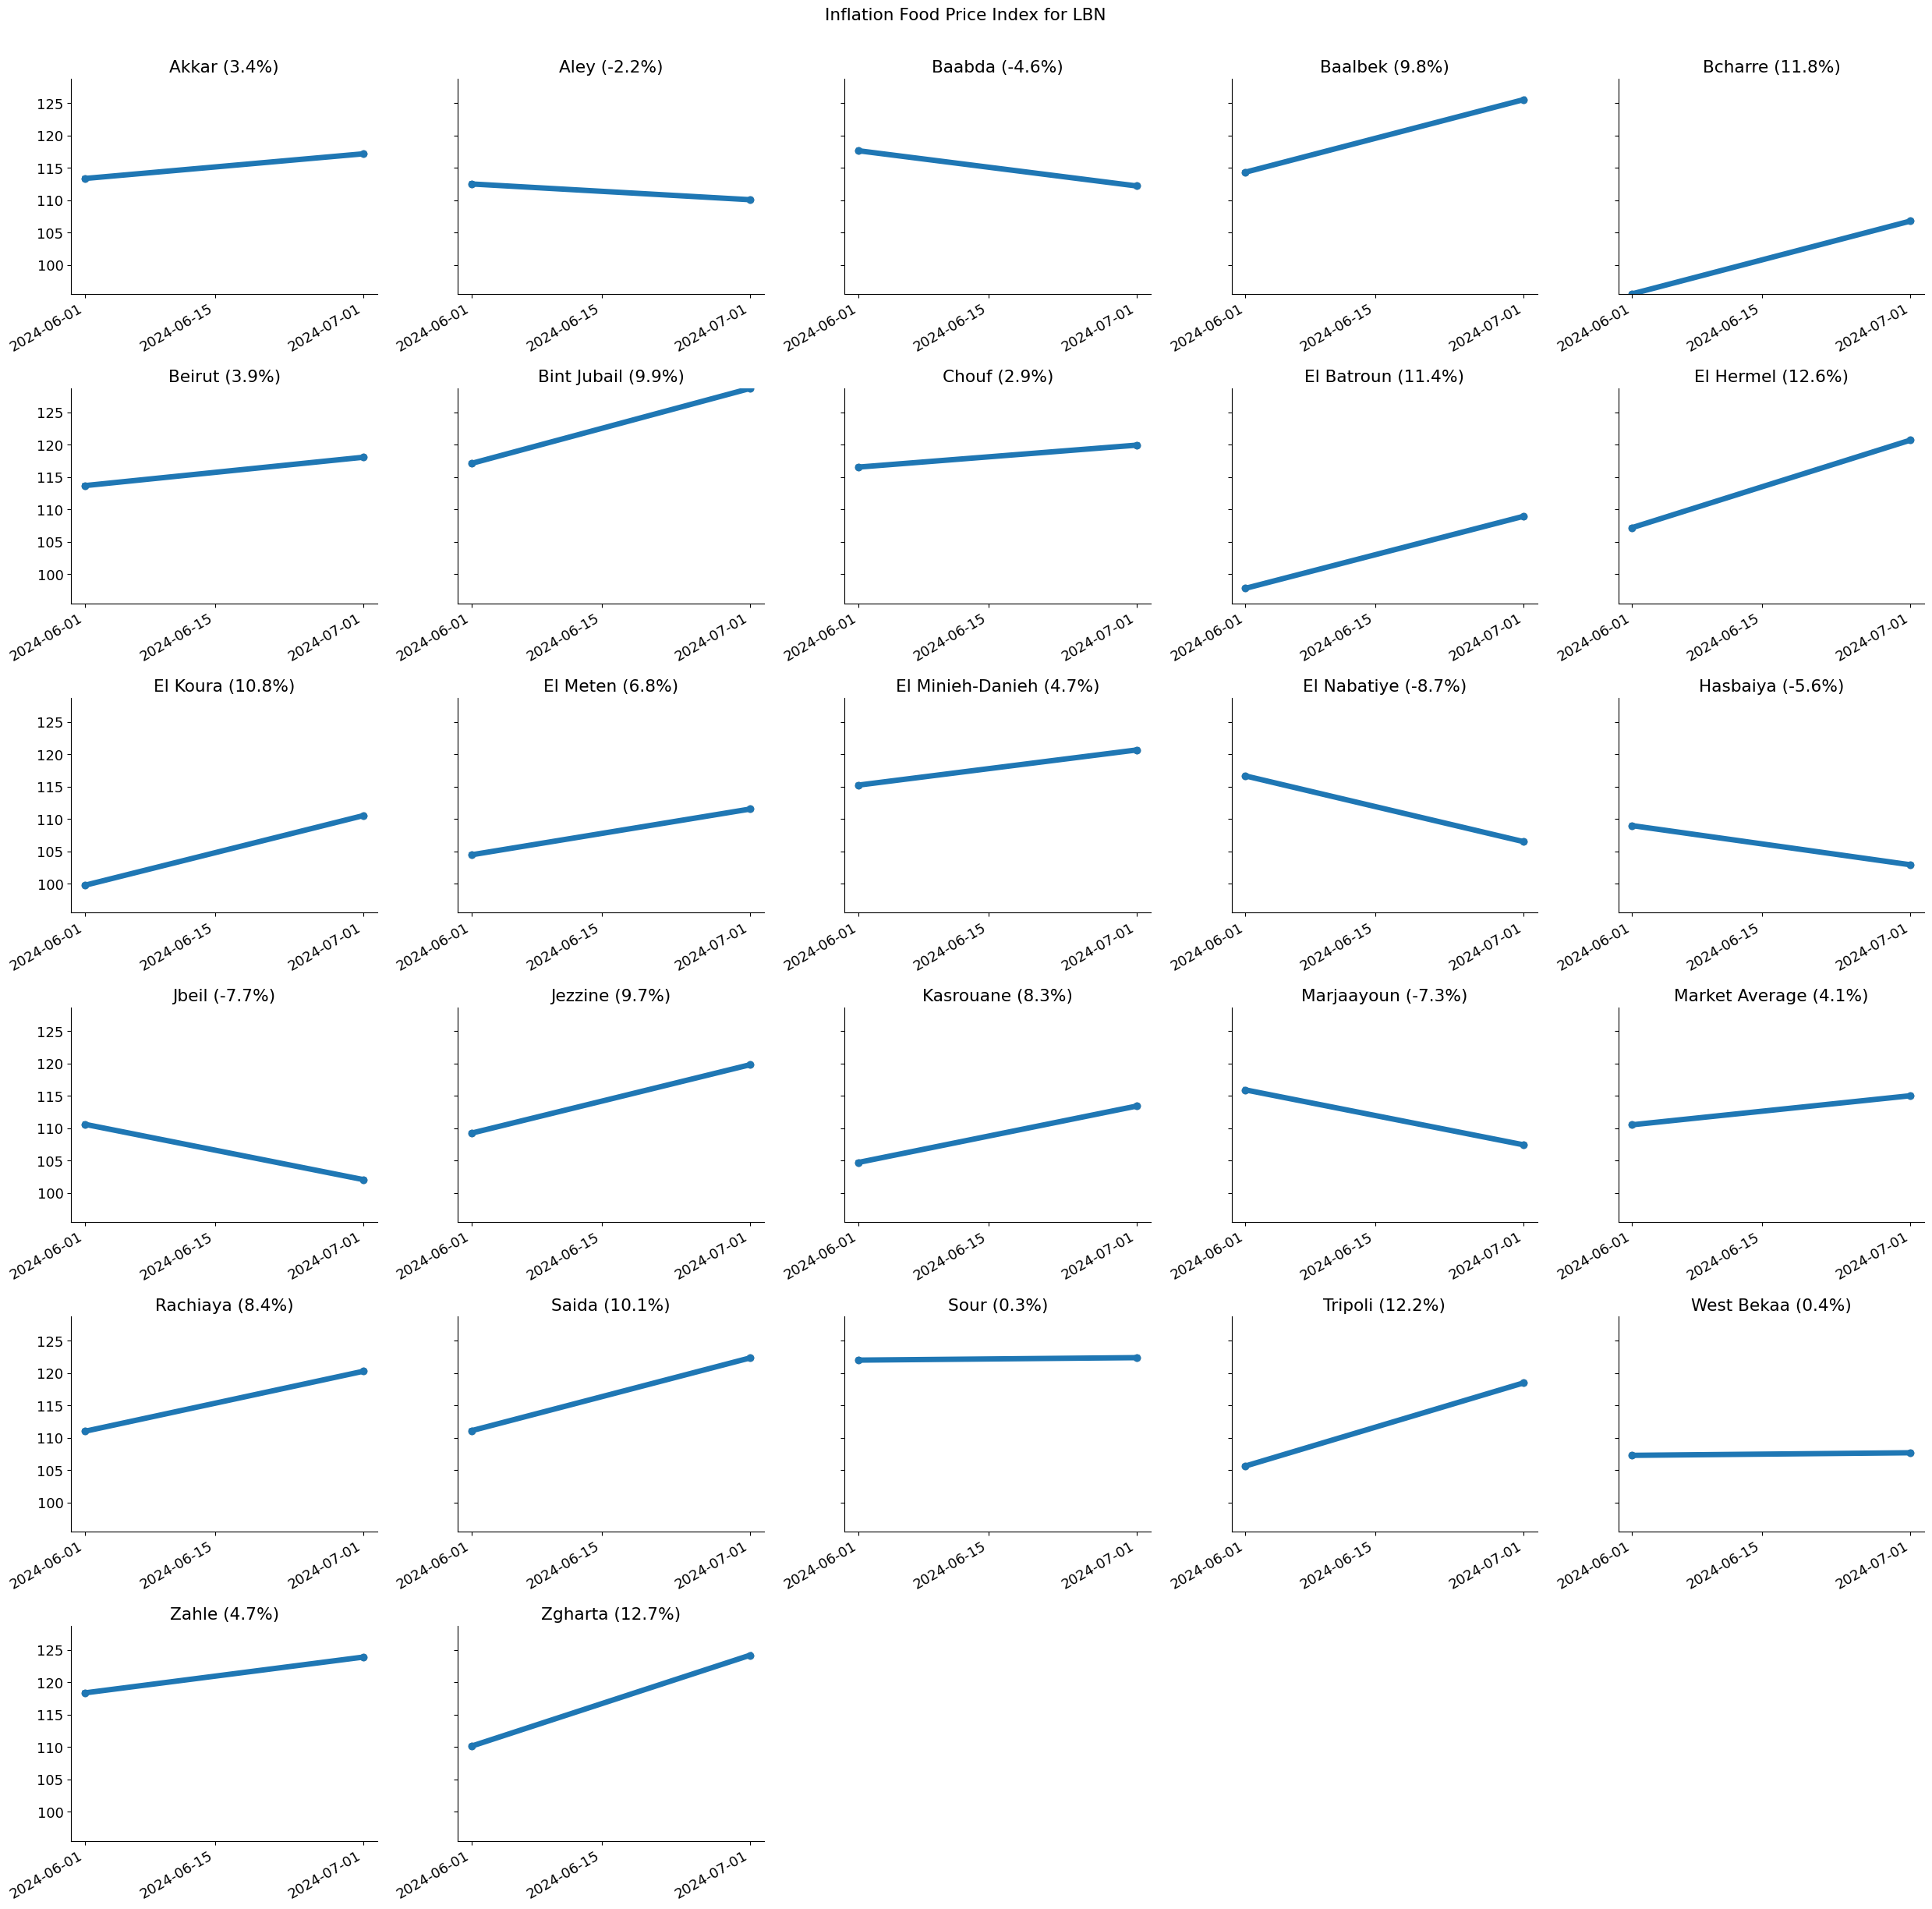

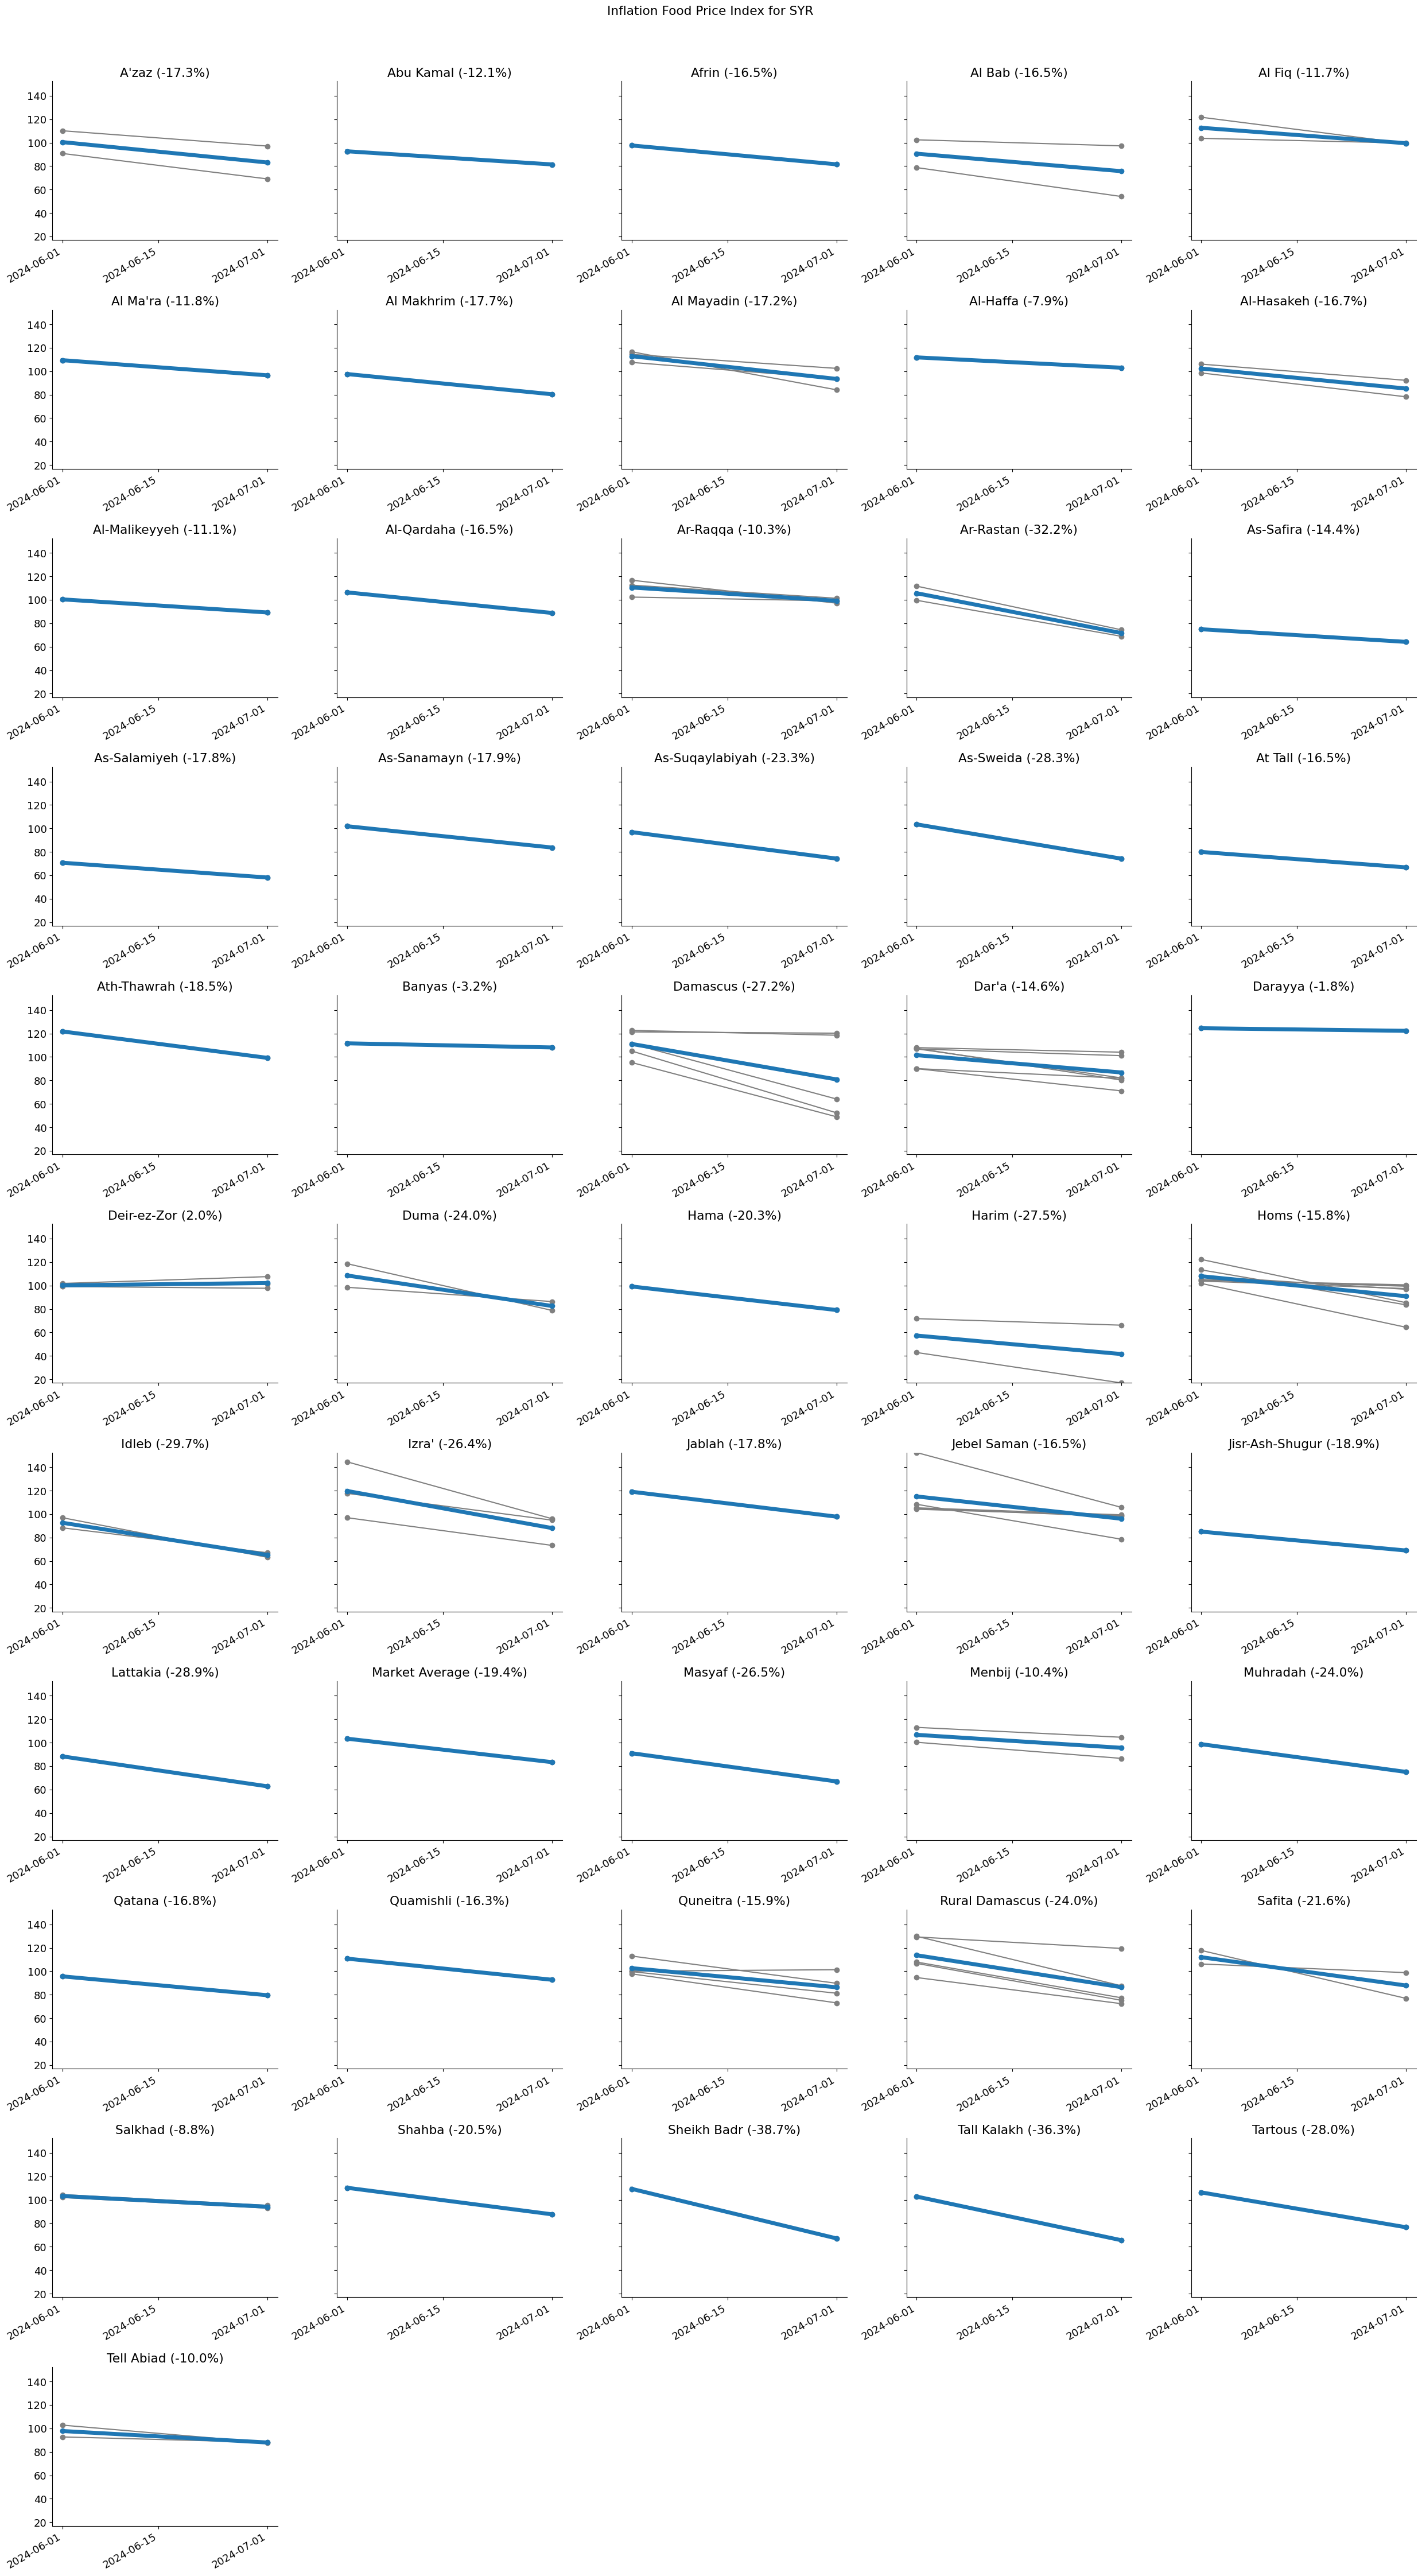

In [40]:
pct_changes = []

for iso in df['ISO3'].unique():
    # Loop through countries
    admin1_list = df[df['ISO3'] == iso]['adm2_name'].unique()
    admin1_list.sort()
    n = len(admin1_list)
    ncols = 5
    nrows = (n + ncols - 1) // ncols
    
    ylim = ylim_dict[iso]

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharey=True)
    axes = axes.flatten()
    # Set up multiplot

    for ax, admin1 in zip(axes, admin1_list):
        group = df[(df['ISO3'] == iso) & (df['adm2_name'] == admin1)]
        
        group.sort_index(inplace=True)
        
        if True:
            # Plot points for each market
            mkt_groups = group.groupby('mkt_name')
            mkt_groups.plot(
                y='inflation_food_price_index',
                
                ax=ax,
                style='o-',
                title=f"{iso} - {admin1}",
                legend=False,
                color = 'grey',
                ylim = ylim
            )
        if True:
            # Plot mean over all markets in admin 2
            group = group[['mkt_name','inflation_food_price_index']]
            group = group.groupby('DATES')['inflation_food_price_index'].mean()
            group.plot(
                y='inflation_food_price_index',
                
                ax=ax,
                style='o-',
                linewidth = 5,
                title=f"{iso} - {admin1}",
                legend=False,
                ylim = ylim
            )
        
        group.sort_index(inplace=True)
        
        pct_change = (group.diff() / group.abs().shift()).values[1]*100
        pct_changes.append([iso, admin1,pct_change])
        
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if ylim[0] < 0.0 and ylim[1] > 0.0:
            ax.axhline(0, linestyle='--', color='grey')
        ax.set_xlabel('')
        ax.set_title('{:s} ({:.1f}%)'.format(admin1,pct_change))
        ax.set_xticks([pd.to_datetime('2024-06-01'), pd.to_datetime('2024-06-15'), pd.to_datetime('2024-07-01')])

    # Hide unused axes
    for ax in axes[len(admin1_list):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.suptitle(f"Inflation Food Price Index for {iso}", y=1.02)
    plt.savefig('../reports/figures/wb_food_inflation_{:s}_adm2_multiplot.png'.format(iso))
    plt.show()

pct_change_df = pd.DataFrame(columns = ['iso','admin1','pct_change'], data = pct_changes)
pct_change_df.to_csv('../data/processed/wb_food_price_changes.csv')

## Bring data from news articles and try to join on location

In [41]:
df_news_ar = pd.read_csv("../data/processed/news_articles_augmented_ar.csv")
df_news_en = pd.read_csv("../data/processed/news_articles_augmented_en.csv")

In [42]:
df_news_en['locations'] = df_news_en['locations'].apply(eval)
df_news_en['risk_factors'] = df_news_en['risk_factors'].apply(eval)
df_news_en['dateTime'] = pd.to_datetime(df_news_en['dateTime'])

df_news_ar['locations'] = df_news_ar['locations'].apply(eval)
df_news_ar['risk_factors'] = df_news_ar['risk_factors'].apply(eval)
df_news_ar['dateTime'] = pd.to_datetime(df_news_ar['dateTime'])

In [43]:
with open("../data/raw/id_english_location_name.pkl", "rb") as f:
    locations_dict_en = pickle.load(f)

with open("../data/raw/id_arabic_location_name.pkl", "rb") as f:
    locations_dict_ar = pickle.load(f)
    
with open("../data/processed/en_locations_reversed.pkl", "rb") as f:
    locations_dict_en_reversed = pickle.load(f)
    
with open("../data/processed/ar_locations_reversed.pkl", "rb") as f:
    locations_dict_ar_reversed = pickle.load(f)


In [44]:
df_news_en.head()

,locations,risk_factors,dateTime
0,"[ps_gz_2, ps, ps, ps, ps, ps]",[other],2024-06-23 00:08:49+00:00
1,"[ps_gz_2, ps_gz_2, iq_an_6, ps_gz_2, ps_gz_2, ...",[other],2024-06-23 00:21:26+00:00
2,"[ps_gz_2, ps_gz_5, ps_gz_2, lb, lb, ps_gz_2, i...",[other],2024-06-23 00:26:33+00:00
3,"[ps_gz_2, ps, ps_gz_2, ps_gz_2, ps_gz_2, ps_gz...",[forced displacement],2024-06-23 00:55:41+00:00
4,"[lb, iq_an_6, lb, iq_an_6, ps_gz_2, ps_gz_2, l...","[other, other, other]",2024-06-23 00:56:20+00:00


In [45]:
def get_from_dict(x:str) -> any:
    '''Helper function to grab an admin 2 code if found'''
    res = locations_dict_en_reversed.get(x.lower())
    if res:
        for r in res:
            if len(r) >5:
                return r
    else:
        return None

In [47]:
pct_change_df['admin1_code'] = pct_change_df['admin1'].apply(get_from_dict)
print(pct_change_df['admin1_code'].isnull().sum())
# 31 out of 97 admin 2s not matched

pct_change_df.set_index('admin1_code', inplace=True)
pct_change_dict = pct_change_df['pct_change'].to_dict()

31


### EN first

In [48]:
for c in ['sy','lb','iq']:
    print(c)
    
    counter_en = collections.Counter(l for locs in df_news_en['locations'] for l in locs)
    counter_en = collections.Counter({k: v for k, v in counter_en.items() if len(k) > 5 and k.startswith(c)})
    
    data = []

    for k,v in counter_en.items():
        pct = pct_change_dict.get(k)
        
        if pct:
            data.append([k,v,pct])
            
    final_df = pd.DataFrame(columns = ['admin_code','news_count','inflation_pct'], data = data)
    
    corr_pearson = final_df["news_count"].corr(final_df["inflation_pct"], method="pearson")
    corr_spearman = final_df["news_count"].corr(final_df["inflation_pct"], method="spearman")
    
    print('Based on {:d} admin 2 regions in {:s} the correlation between food price inflation and news article mentions is'.format(final_df.shape[0], c))
    print('Pearson = {:.2f}'.format(corr_pearson))
    print('Spearman = {:.2f}'.format(corr_spearman))
    print('-----')


sy
Based on 21 admin 2 regions in sy the correlation between food price inflation and news article mentions is
Pearson = -0.30
Spearman = -0.19
-----
lb
Based on 15 admin 2 regions in lb the correlation between food price inflation and news article mentions is
Pearson = -0.05
Spearman = 0.06
-----
iq
Based on 11 admin 2 regions in iq the correlation between food price inflation and news article mentions is
Pearson = -0.32
Spearman = -0.09
-----


In [49]:
for c in ['sy','lb','iq']:
    print(c)
    
    counter_ar = collections.Counter(l for locs in df_news_ar['locations'] for l in locs)
    counter_ar = collections.Counter({k: v for k, v in counter_ar.items() if len(k) > 5 and k.startswith(c)})
    
    data = []

    for k,v in counter_ar.items():
        pct = pct_change_dict.get(k)
        
        if pct:
            data.append([k,v,pct])
            
    final_df = pd.DataFrame(columns = ['admin_code','news_count','inflation_pct'], data = data)
    
    corr_pearson = final_df["news_count"].corr(final_df["inflation_pct"], method="pearson")
    corr_spearman = final_df["news_count"].corr(final_df["inflation_pct"], method="spearman")
    
    print('Based on {:d} admin 2 regions in {:s} the correlation between food price inflation and news article mentions is'.format(final_df.shape[0], c))
    print('Pearson = {:.2f}'.format(corr_pearson))
    print('Spearman = {:.2f}'.format(corr_spearman))
    print('-----')


sy
Based on 26 admin 2 regions in sy the correlation between food price inflation and news article mentions is
Pearson = -0.21
Spearman = 0.05
-----
lb
Based on 19 admin 2 regions in lb the correlation between food price inflation and news article mentions is
Pearson = -0.04
Spearman = 0.09
-----
iq
Based on 14 admin 2 regions in iq the correlation between food price inflation and news article mentions is
Pearson = -0.19
Spearman = 0.01
-----
